# TCC2

## Engenharia de Sistemas - UFMG
---
Autor: Thullio Debortoli Moreira Zanetti

Orientador: Frederico Gadelha Guimarães

## 1) Limpar  e transformar base de dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sqlite3
import pandas as pd 
import numpy as np
#from google.colab import files
import matplotlib.pylab as plt
%matplotlib inline

In [0]:
#df = pd.read_csv(files.download("drive/UFMG/TCC2/Algoritmo/database/loan.csv"), sep=',', usecols = ["loan_status", "loan_amnt", "term", "int_rate"]) 
#['Fully Paid', 'Charged Off', 'Current', 'Default',
#       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
#       'Does not meet the credit policy. Status:Fully Paid',
#       'Does not meet the credit policy. Status:Charged Off', 'Issued']
conn = sqlite3.connect('/content/drive/My Drive/UFMG/TCC2/Algoritmo/database/database.sqlite')
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
df_db = pd.read_sql_query("select * from loan where loan_status = 'Fully Paid' OR loan_status = 'Charged Off' OR loan_status = 'Default'", con=conn, parse_dates = to_parse)

Pimeiramente são excluidas as colunas e as linhas que contém mais de 50% dos seus valores nulos, pois não possuem informação suficiente para o problema

In [0]:
df = df_db
df.dropna(axis=1, thresh=int(df.shape[0]*0.5), inplace=True)
df.dropna(axis=0, thresh=int(df.shape[1]*0.5), inplace=True)

Das colunas restantes, como para predição são utilizados apenas dados coletados anteriormente à concessão do empréstimo, algumas colunas não possuem sentido para o problema. Outras são campos aberto e também não agragam valor.


*   Colunas excluídas: index, id, member_id, issue_d, initial_list_status, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, pymnt_plan, url, zip_code, addr_state, grade, emp_title, purpose, policy_code, title

*   Colunas mantidas: loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, sub_grade, emp_length, home_ownership, annual_inc, verification_status, loan_status, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, recoveries,  application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim

Depois verifica-se quais colunas são do tipo texto para que sejam transformadas.



In [0]:
columns_to_keep =  ['loan_amnt',
                    'funded_amnt',
                    'funded_amnt_inv',
                    'term',
                    'int_rate',
                    'installment',
                    'sub_grade',
                    'emp_length',
                    'home_ownership',
                    'annual_inc',
                    'verification_status',
                    'loan_status',
                    'dti',
                    'delinq_2yrs',
                    'earliest_cr_line',
                    'inq_last_6mths',
                    'open_acc',
                    'pub_rec',
                    'revol_bal',
                    'revol_util',
                    'total_acc',
                    'recoveries',
                    'application_type',
                    'acc_now_delinq',
                    'tot_coll_amt',
                    'tot_cur_bal',
                    'total_rev_hi_lim']
df = df[columns_to_keep]
#df.dtypes  #get column types

**Segue relação de colunas e transformações a serem realizadas:**

Coluna | Ex valor atual | Ex novo valor | Novo nome
:---: | :---: | :---: | :---:
term |  36 m | 36 | -
int_rate | 10% | 0.1 | -
sub_grade | [A1 - G5] | [35 - 1] | grade
emp_length | 1 year | 1 | -
home_ownership | own/other | 1/0 |  own_home              
verification_status | Verified/Not Verified | 1/0 | verified
loan_status | Fully Paid/Charged off | 1/0 | fully_paid
earliest_cr_line | DateTime | Month/Year |  -
revol_util | 10% | 0.1 | -
application_type | INDIVIDUAL/JOINT | 1/0 | individual

In [ ]:
#Define range transformation
grades = {'A1' : 35, 'A2' : 34, 'A3' : 33, 'A4' : 32, 'A5' : 31, 'B1' : 30, 'B2' : 29, 'B3' : 28, 'B4' : 27, 'B5' : 26, 'C1' : 25, 'C2' : 24, 'C3' : 23, 'C4' : 22, 'C5' : 21, 'D1' : 20, 'D2' : 19, 'D3' : 18, 'D4' : 17, 'D5' : 16, 'E1' : 15, 'E2' : 14, 'E3' : 13, 'E4' : 12, 'E5' : 11, 'F1' : 10, 'F2' : 9, 'F3' : 8, 'F4' : 7, 'F5' : 6, 'G1' : 5, 'G2' : 4, 'G3' : 3, 'G4' : 2, 'G5' : 1}

#applying transformations
df['term'] = df['term'].str.split(' ').str[1]
df['int_rate'] = (df['int_rate'].str.split('%').str[0]).astype(float)/100.
df["sub_grade"] = df["sub_grade"].replace(grades)
# extract numbers from emp_length and fill missing values with the median
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length'] = df['emp_length'].fillna(df.emp_length.median())
df['home_ownership'] = df['home_ownership'].apply(lambda x : 1 if x == 'OWN' else 0)
df['verification_status'] = df['verification_status'].apply(lambda x : 0 if x == 'Not Verified' else 1)
df['loan_status'] = df['loan_status'].apply(lambda x : 1 if x == 'Fully Paid' else 0)
df['earliest_cr_line'] = df['earliest_cr_line'].dt.to_period('M')
df['revol_util'] = (df['revol_util'].str.split('%').str[0]).astype(float)/100.
df['application_type'] = df['application_type'].apply(lambda x : 1 if x == 'INDIVIDUAL' else 0)

df = df.rename(index=str, columns={"loan_status": "fully_paid", 
                              "sub_grade": "grade", 
                              "home_ownership" : "own_home", 
                              "verification_status" : "verified", 
                              "application_type" : "individual"})

A partir das características restantes, foram criadas novas caracteristicas em busca de uma informação melhor. As colunas funded_amnt e funded_amnt_inv foram substituídas pelo percentual dos valores em relação ao montante do empréstimo.

In [0]:
df['funded_amnt'] = df['funded_amnt']/df['loan_amnt']
df['funded_amnt_inv'] = df['funded_amnt_inv']/df['loan_amnt']

Após a transformação dos dados, os mesmos são filtrados de acordo com a correlação dos mesmos com a saída. São retirados as variáveis com valor absoluto de correlação menor que 0,01 com a saída. Após este filtro, retaram 15 parâmetros de entrada finais.

In [0]:
df = df.fillna(0)
df = df[df.corr()['fully_paid'][np.absolute(df.corr()['fully_paid']) > 0.01].index]

In [9]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'annual_inc',
       'verified', 'fully_paid', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'revol_util', 'total_acc', 'recoveries', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

# 2) Modelos de IA

10% do dataset sera separado para testes e comparação dos resultados. Todos os modelos serão treinados utilizando o método K-fold dividindo-se o dataset em 9 partes iguais.

## 2.1) Decision Tree

A primeira técnica de inteligência artificial a ser aplicada é a de uma árvore de decisão.

In [0]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.externals import joblib
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
#Separar Entrada e Saída
y = df['fully_paid']
X = df.drop(['fully_paid'], axis=1)
errorI = []
errorII = []
accuracy = []
roc_auc_score = []
out_test = []
out_prob = []

for t in range(0, 30):
  # Define entrada e saída para treinamento e teste (10% da amostra)
  '''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  #Treinar modelo utilizando GridSearchCV e variando profundidade da arvore de 3 a 20, com 9 folds
  #Algoritmo utilizado para gerar o classificador:
  parameters = {'max_depth':range(3,20)}
  decTreeClf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv = 9)
  decTreeClf.fit(X=X_train, y=y_train)
  
  decTreeClf.X_train = X_train
  decTreeClf.X_test = X_test
  decTreeClf.y_train = y_train
  decTreeClf.y_test = y_test

  with open('/content/drive/My Drive/UFMG/TCC2/Algoritmo/classifiers/Decision Tree without augmentation/decisionTreeCLF{}.pkl'.format(t), 'wb') as f:
      pickle.dump(decTreeClf, f) # save the object to a file'''

  with open('/content/drive/My Drive/UFMG/TCC2/Algoritmo/classifiers/Decision Tree without augmentation/decisionTreeCLF{}.pkl'.format(t), 'rb') as f:
      decTreeClf = pickle.load(f)
      
  X_train = decTreeClf.X_train
  X_test = decTreeClf.X_test
  y_train = decTreeClf.y_train
  y_test = decTreeClf.y_test
  
  #Testar modelo obtido
  y_predict_tree = decTreeClf.predict(X_test)
  y_difference_tree = y_test - y_predict_tree
  y_pred_proba = decTreeClf.predict_proba(X_test)[::,1]
  out_test.extend(y_test)
  out_prob.extend(y_pred_proba)
  errorI.append(float(y_difference_tree[y_difference_tree == -1].shape[0])/float(y_difference_tree.shape[0]))
  errorII.append(float(y_difference_tree[y_difference_tree == 1].shape[0])/float(y_difference_tree.shape[0]))
  accuracy.append(float(y_difference_tree[y_difference_tree == 0].shape[0])/float(y_difference_tree.shape[0]))
  roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred_proba))

Mean Type I error (FP): 0.08780
Mean Type II error (FN): 0.00000
Mean Accuracy: 0.91220
Mean ROC_AUC_Score: 0.83788




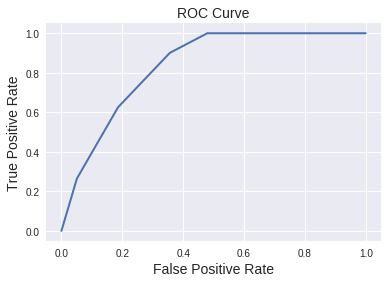

In [25]:
print ('Mean Type I error (FP): {0:.5f}'.format(np.mean(errorI)))
print ('Mean Type II error (FN): {0:.5f}'.format(np.mean(errorII)))
print ('Mean Accuracy: {0:.5f}'.format(np.mean(accuracy)))
print ('Mean ROC_AUC_Score: {0:.5f}\n\n'.format(np.mean(roc_auc_score)))
#print 'Mean Depth: {0:.5f}\n\n'.format(np.mean(depth))

idx_max = np.argmax(accuracy)


y_test = out_test[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]
y_pred_proba = out_prob[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, linewidth=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.show()

In [0]:
# Codigo para conseguir printar datas
%%bash
/usr/bin/yes | apt-get install graphviz
pip install --upgrade graphviz
/usr/bin/yes | pip uninstall pyparsing
pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
pip install --upgrade pydot
pip install pydotplus

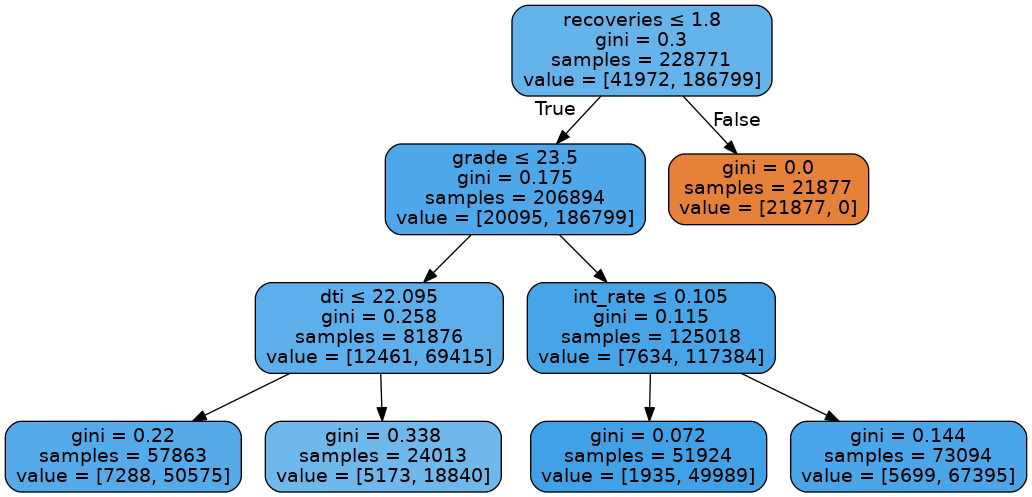

In [27]:
with open('/content/drive/My Drive/UFMG/TCC2/Algoritmo/classifiers/Decision Tree without augmentation/decisionTreeCLF{}.pkl'.format(idx_max), 'rb') as f:
  decTreeClf = pickle.load(f)

tree_model = decTreeClf.best_estimator_

# Draw Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data, feature_names=X.columns, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 2.1.1) Desbalanceamento de dados
Os resultados do primeiro modelo de Decision Tree não foram satisfatórios, então foi buscado um motivo para tal resultado. A justificativa para ter um modelo que leva apenas uma variável em consideração é o desbalancemaneto de dados, no qual a parcela de dados de clientes que pagaram integralmente o empréstimo é de  81.72% dos dados totais. Para isto, será empregado uma técnica de oversampling no treinamento dos modelos, para que equalize as classes.

Para isso,também será criado uma função para separar os dados de teste de forma balanceada, usando 5.48% dos dados totais, dos quais metade serão da classe *inadimplentes*, o que representa 15% da classe. Este número foi escolhido para que não ocorra perda de características da classe para o treinamento. 

In [0]:
from sklearn.utils import shuffle

def balanced_subsample(x, y, subsample_minority_class_size=0.15):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_minority_class_size < 1:
        use_elems = int(min_elems*subsample_minority_class_size)

    x_test = []
    y_test = []
    x_train = []
    y_train = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = shuffle(this_xs)

        xs_test = this_xs[:use_elems]
        ys_test = np.empty(use_elems)
        ys_test.fill(ci)
        
        xs_train = this_xs[use_elems:]
        ys_train = np.empty(xs_train.shape[0])
        ys_train.fill(ci)

        x_test.append(xs_test)
        y_test.append(ys_test)
        
        x_train.append(xs_train)
        y_train.append(ys_train)

    x_test, y_test = shuffle(np.concatenate(x_test), np.concatenate(y_test), random_state=0)
    x_train, y_train = shuffle(np.concatenate(x_train), np.concatenate(y_train), random_state=0)

    return x_train, x_test, y_train, y_test

### 2.1.2) Decision Tree with oversampling

In [0]:
!pip uninstall imbalanced-learn
!pip install imbalanced-learn==0.3.0

In [0]:
import imblearn

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
def get_clf_with_oversampling(X, y, path, train, parameters, method, save_method):
  errorI = []
  errorII = []
  accuracy = []
  roc_auc_score = []
  out_test = []
  out_prob = []

  for t in range(0, 30):
    if train:
      # Define entrada e saída para treinamento e teste
      X_train, X_test, y_train, y_test = balanced_subsample(X, y)

      #Oversampling
      sm = SMOTE(random_state=42)
      X_train, y_train = sm.fit_sample(X_train, y_train)

      #Algoritmo utilizado para gerar o classificador:
      clf = GridSearchCV(method, parameters, n_jobs=4, cv = 9, verbose=5)
      clf.fit(X=X_train, y=y_train)

      clf.X_train = X_train
      clf.X_test = X_test
      clf.y_train = y_train
      clf.y_test = y_test
      
      if save_method == 'sav':
        with open('{}{}.sav'.format(path, t), 'wb') as f:
            joblib.dump(clf, f) # save the object to a file
            
      else:
        with open('{}{}.pkl'.format(path, t), 'wb') as f:
          clf = pickle.dump(clf, f)
          
    else:
      if save_method == 'sav':
        with open('{}{}.sav'.format(path, t), 'rb') as f:
            clf = joblib.load(f)
            
      else:
        with open('{}{}.pkl'.format(path, t), 'rb') as f:
          clf = pickle.load(f)
      

      X_train = clf.X_train
      X_test = clf.X_test
      y_train = clf.y_train
      y_test = clf.y_test

    #Testar modelo obtido
    y_predict_tree = clf.predict(X_test)
    y_difference_tree = y_test - y_predict_tree
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    out_test.extend(y_test)
    out_prob.extend(y_pred_proba)
    errorI.append(float(y_difference_tree[y_difference_tree == -1].shape[0])/float(y_difference_tree.shape[0]))
    errorII.append(float(y_difference_tree[y_difference_tree == 1].shape[0])/float(y_difference_tree.shape[0]))
    accuracy.append(float(y_difference_tree[y_difference_tree == 0].shape[0])/float(y_difference_tree.shape[0]))
    roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred_proba))
    
  print ('Mean Type I error (FP): {0:.5f}'.format(np.mean(errorI)))
  print ('Mean Type II error (FN): {0:.5f}'.format(np.mean(errorII)))
  print ('Mean Accuracy: {0:.5f}'.format(np.mean(accuracy)))
  print ('Mean ROC_AUC_Score: {0:.5f}\n\n'.format(np.mean(roc_auc_score)))
  #print 'Mean Depth: {0:.5f}\n\n'.format(np.mean(depth))

  idx_max = np.argmax(accuracy)


  y_test = out_test[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]
  y_pred_proba = out_prob[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]

  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
  plt.plot(fpr,tpr, linewidth=2)
  plt.xlabel("False Positive Rate", fontsize=14)
  plt.ylabel("True Positive Rate", fontsize=14)
  plt.title("ROC Curve", fontsize=14)
  plt.show()
  
  return idx_max

Mean Type I error (FP): 0.23303
Mean Type II error (FN): 0.00987
Mean Accuracy: 0.75710
Mean ROC_AUC_Score: 0.83447




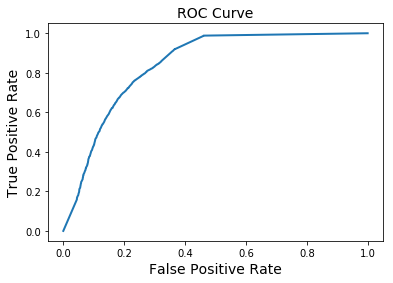

In [0]:
#Separar Entrada e Saída
y = df['fully_paid']
X = df.drop(['fully_paid'], axis=1)

#Parametros para a decision tree
path = './classifiers/Decision Tree with augmentation/decisionTreeCLF'
#Treinar modelo variando profundidade da arvore de 3 a 20, com 9 folds
parameters = {'max_depth':range(3,20)}
method = tree.DecisionTreeClassifier()
idx_max = get_clf_with_oversampling(X, y, path, False, parameters, method, 'pkl') #Mudar para True, se quiser retreinar modelo

In [0]:
# Codigo para conseguir printar datas
#%%bash
!/C:/Users/Thullio/Anaconda3/Lib/site-packages | apt-get install graphviz
!pip install --upgrade graphviz
!/c/Users/Thullio/Anaconda3/Lib/site-packages | pip uninstall pyparsing
!pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
!pip install --upgrade pydot
!pip install pydotplus

In [0]:
!pip install graphviz

In [0]:
# Draw Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
import pydot

In [0]:
with open('./classifiers/Decision Tree with augmentation/decisionTreeCLF{}.pkl'.format(idx_max), 'rb') as f:
  decTreeClf = pickle.load(f)

tree_model = decTreeClf.best_estimator_

In [0]:
#from graphviz import Source
#dot_data = StringIO()
#export_graphviz(tree_model, out_file=dot_data, feature_names=X.columns, 
#                filled=True, rounded=True,
 #               special_characters=True)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_pdf("./Resultados/dec_tree_with_oversampling.pdf")
#Image(graph.create_png())

In [0]:
#Pegar as valores médios de cada classificador
feature_importances = [0]*X.shape[1]
max_depth_dt = 0
for i in range(0,30):
    with open('./classifiers/Decision Tree with augmentation/decisionTreeCLF{}.pkl'.format(i), 'rb') as f:
      clf = pickle.load(f)
    feature_importances = feature_importances+clf.best_estimator_.feature_importances_
    max_depth_dt = max_depth_dt+clf.best_params_['max_depth']
    
print('O valor médio do hiperparâmetro escolhido foi: max_depth = {}'.format(max_depth_dt/30))

O valor médio do hiperparâmetro escolhido foi: max_depth = 18.3


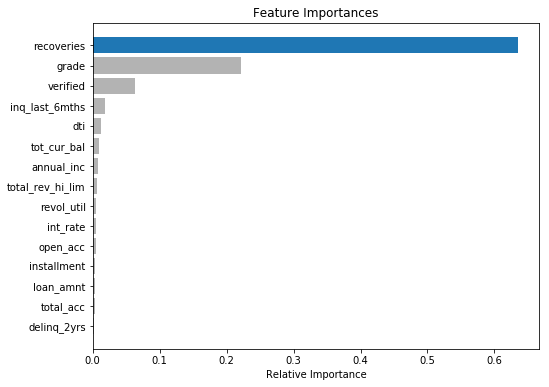

In [0]:
importances = feature_importances/30
indices = np.argsort(importances)
colors = ['0.7']*(indices.shape[0] - 1) + ['tab:blue']

plt.figure(1, figsize=(8, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=colors, align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')

### 2.2) Random Forest with oversampling

Mean Type I error (FP): 0.23889
Mean Type II error (FN): 0.00013
Mean Accuracy: 0.76098
Mean ROC_AUC_Score: 0.86164




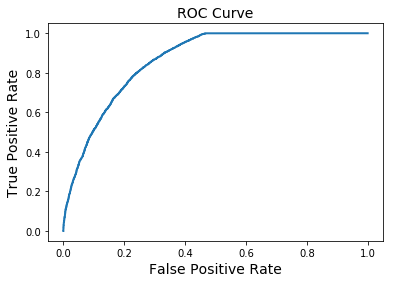

In [0]:
from sklearn.ensemble import RandomForestClassifier
#Parametros para a decision tree
path = './classifiers/Random Forest/randomForestCLF'
#Treinar modelo variando profundidade da arvore de 3 a 20, o numero de arvores da random forest de 10 a 100 e com 9 folds
parameters = {'max_depth':[5,10,15], "n_estimators":[10,30,50]}
method = RandomForestClassifier()
idx_max = get_clf_with_oversampling(X, y, path, False, parameters, method, 'sav') #Mudar para True, se quiser retreinar modelo

In [0]:
with open('./classifiers/Random Forest/randomForestCLF{}.sav'.format(idx_max), 'rb') as f:
  clf = joblib.load(f)

random_forest = clf.best_estimator_

dot_data = StringIO()
export_graphviz(random_forest.estimators_[5], out_file=dot_data, feature_names=X.columns, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./Resultados/random_forest_with_oversampling.pdf")
Image(graph.create_png())

In [0]:
#Pegar as valores médios de cada classificador
feature_importances = [0]*X.shape[1]
max_depth_rf = 0
n_estimators = 0
for i in range(0,30):
    with open('./classifiers/Random Forest/randomForestCLF{}.sav'.format(i), 'rb') as f:
      clf = joblib.load(f)
    feature_importances = feature_importances+clf.best_estimator_.feature_importances_
    max_depth_rf = max_depth_rf+clf.best_params_['max_depth']
    n_estimators = n_estimators+clf.best_params_['n_estimators']
    
print('Os valores médios dos hiperparâmetros escolhidos foram: max_depth = {} e n_estimators = {}'.format(max_depth_rf/30,n_estimators/30))

Os valores médios dos hiperparâmetros escolhidos foram: max_depth = 15.0 e n_estimators = 44.0


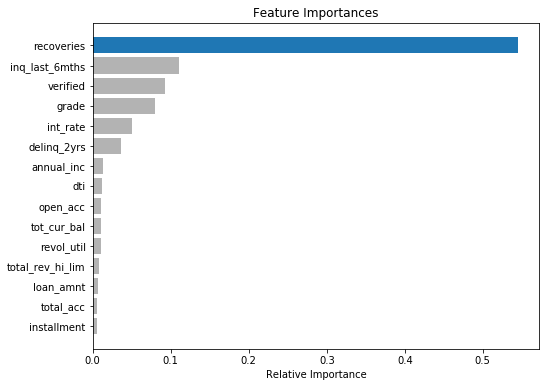

In [0]:
importances = feature_importances/30
indices = np.argsort(importances)
colors = ['0.7']*(indices.shape[0] - 1) + ['tab:blue']

plt.figure(1, figsize=(8, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=colors, align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')

### 2.3) Neural Network

In [0]:
import tensorflow as tf

In [0]:
# Helper class to perform K-Folds Validation splitting
class CrossValidationFolds(object):
    
    def __init__(self, data, labels, num_folds, shuffle=True):
        self.data = data
        self.labels = labels
        self.num_folds = num_folds
        self.current_fold = 0
        
        # Shuffle Dataset
        if shuffle:
            perm = np.random.permutation(self.data.shape[0])
            data = data[perm]
            labels = labels[perm]
    
    def split(self):
        current = self.current_fold
        size = int(self.data.shape[0]/self.num_folds)
        
        index = np.arange(self.data.shape[0])
        lower_bound = index >= current*size
        upper_bound = index < (current + 1)*size
        cv_region = lower_bound*upper_bound

        cv_data = self.data[cv_region]
        train_data = self.data[~cv_region]
        
        cv_labels = self.labels[cv_region]
        train_labels = self.labels[~cv_region]
        
        self.current_fold += 1
        return (train_data, train_labels), (cv_data, cv_labels)

####2.3.1) Normalizing Data

In [0]:
# Separar Entrada e Saída
y_data = df['fully_paid']
X_data = df.drop(['fully_paid'], axis=1)
X_data = (X_data-X_data.mean())/(pow(X_data.std(), 2) + 0.0001)
X_data = (X_data-X_data.min())/(X_data.max() - X_data.min()).values

In [18]:
# Parameters
learning_rate = 0.01
training_epochs = 100
FOLDS = 9

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam, SGD
from keras.constraints import maxnorm
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from keras.models import load_model

def create_baseline():
  # create model
  model = Sequential()
  model.add(Dense(9, input_dim=15, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh'))
  model.add(Dense(1, kernel_initializer='normal', activation='tanh'))
  # Compile model                                                         , amsgrad=True
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=learning_rate), metrics=['accuracy'])
  return model

Using TensorFlow backend.


Mean Type I error (FP): 0.17934
Mean Type II error (FN): 0.11204
Mean Accuracy: 0.70862
Mean ROC_AUC_Score: 0.78674




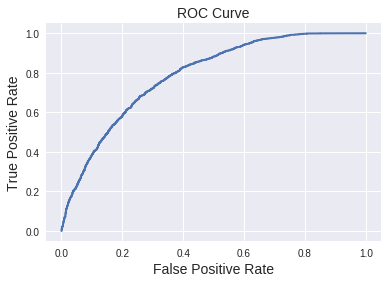

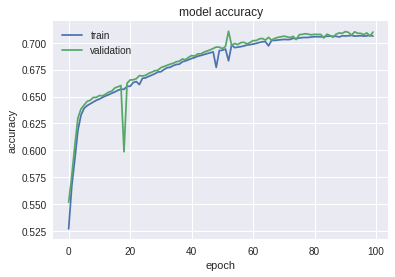

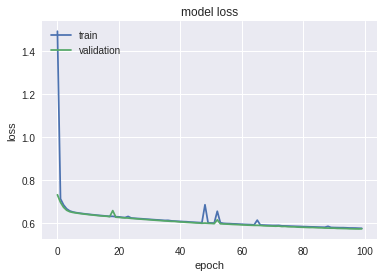

In [21]:
#Definir path
path = '/content/drive/My Drive/UFMG/TCC2/Algoritmo/classifiers/MLP_oversampling/MLPCLF'

encoder = LabelEncoder()
encoder.fit(y_data)
y_data = encoder.transform(y_data)
seed = 10
np.random.seed(seed)

best_estimators = []
best_histories = []
best_accs = []
errorI = []
errorII = []
accuracy = []
roc_auc_score = []
out_test = []
out_prob = []

for i in range(30):  
  # Define entrada e saída para treinamento e teste
  X_train, X_test, y_train, y_test = balanced_subsample(X_data, y_data)

  #Oversampling
  sm = SMOTE(random_state=42)
  X_train, y_train = sm.fit_sample(X_train, y_train)

  #Results Arrays
  estimators = []
  histories = []
  last_acc = []
  fold = 0
  #Algoritmo utilizado para gerar o classificador:
  kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
  for train_index, val_index in kfold.split(X_train, y_train):
    fold = fold+1
    X_trainning, X_val = X_train[train_index], X_train[val_index]
    y_trainning, y_val = y_train[train_index], y_train[val_index]

    estimator = KerasClassifier(build_fn=create_baseline, epochs=training_epochs, batch_size=1500, verbose=0)
    
    history = estimator.fit(X_trainning, y_trainning, validation_data=(X_val, y_val))

    estimators.append(estimator)
    histories.append(history)
    last_acc.append(history.history['val_acc'][-1])

  idx_max = np.argmax(last_acc)
  best_estimators.append(estimators[idx_max])
  best_histories.append(histories[idx_max])
  best_accs .append(last_acc[idx_max])

  best_estimator = estimators[idx_max]

  best_estimator.model.save('{}{}.h5'.format(path, i))
  
  #test and store 'test data'
  #Testar modelo obtido
  y_predict = best_estimator.predict(X_test)
  y_difference = y_test - y_predict.reshape(y_predict.shape[0])
  y_pred_proba = best_estimator.predict_proba(X_test)[::,1]
  out_test.extend(y_test)
  out_prob.extend(y_pred_proba)
  errorI.append(float(y_difference[y_difference == -1].shape[0])/float(y_difference.shape[0]))
  errorII.append(float(y_difference[y_difference == 1].shape[0])/float(y_difference.shape[0]))
  accuracy.append(float(y_difference[y_difference == 0].shape[0])/float(y_difference.shape[0]))
  roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred_proba))

print ('Mean Type I error (FP): {0:.5f}'.format(np.mean(errorI)))
print ('Mean Type II error (FN): {0:.5f}'.format(np.mean(errorII)))
print ('Mean Accuracy: {0:.5f}'.format(np.mean(accuracy)))
print ('Mean ROC_AUC_Score: {0:.5f}\n\n'.format(np.mean(roc_auc_score)))

idx_max = np.argmax(accuracy)


y_test = out_test[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]
y_pred_proba = out_prob[int(idx_max*(len(out_test)/30)):int((idx_max*(len(out_test)/30))+(len(out_test)/30))]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, linewidth=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.show()

history = best_histories[0]

#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

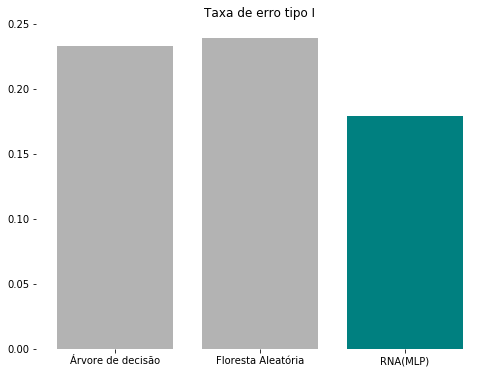

In [10]:
x = ['Árvore de decisão', 'Floresta Aleatória', 'RNA(MLP)']
y = [0.23303,0.23889,0.17934]
colors = ['0.7','0.7','teal']

plt.figure(1, figsize=(8, 6))
plt.title('Taxa de erro tipo I')
plt.bar(range(len(x)), y, color=colors, align='center')
plt.xticks(range(len(x)), x)

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)